In [1]:
import numpy as np
from typing import Tuple
def evalfunc(portfolio: np.ndarray, ret: np.ndarray, pi: float, theta: float) -> float:
    """
    Task 1: the objective function
    (Remember to vectorize as much as possible)


    Parameters
    --------------
    portfolio: np.ndarray: the portfolio vector i.e. x

    ret: np.ndarray: the (T, 3) numpy array containing all asset returns

    pi: float: the exponent parameter of the objective

    theta: the risk-aversion parameter of the objective


    Returns
    --------------
    float: the objective value.
    """
    # compute mean returns first. ret_mu shape should be (3,)
    ret_mu = ret.mean(axis=0)

    # first part
    drift = -ret_mu.dot(portfolio)

    # second part
    # weighed deviation from mean (part within []^pi)
    deviation = (ret - ret_mu).dot(portfolio)
    risk = theta * (
        (deviation**pi).mean()
    )**(1/pi)
    return drift + risk

Consider that since $\textbf{x}$ is by nature a vector of portfolio weights, hence it must sum to $1$. Then, set $x_c = 1-\sum_{j\neq c} x_j$, we have new objective function with $|\textbf{x}|=c-1$:
\begin{align*}
\min -\sum_{j\neq c} \bar{r}_jx_j - \bar{r}_cx_c + \theta\left(
	\frac{1}{T}\sum_{t=1}^T\left[
		\sum_{j\neq c} ((r_{j,t}-\bar{r}_j)x_j)
		+(r_{c,t}-\bar{r}_c)x_c
	\right]^\pi
\right)^{1/\pi}
\end{align*}
Alternatively, in matrix notation, with \textbf{r} denoting the return matrix without the last column, $r_c$, 
\begin{align*}
\min -(\bar{\textbf{r}}-\bar{r_c}'\textbf{1})'\textbf{x}-\bar{r}_c+\frac{\theta}{T^{1/\pi}}||(\tilde{\textbf{r}}-\tilde{r}_c)'\textbf{x} + \tilde{r}_c'\textbf{1}||_\pi
\end{align*}
where $\tilde{x} = x - \bar{x}$. Using the identity
\begin{align*}
\frac{\partial ||\textbf{x}||_p}{\partial \textbf{x}}&=\frac{\textbf{x}\circ |\textbf{x}|^{p-2}}{||\textbf{x}||_p^{p-1}}
\end{align*}
we easily see
\begin{align*}
\nabla \textbf{x} &= (-\bar{\textbf{r}} - \textbf{1}'\bar{r}_c) + \frac{\theta}{T^{1/\pi}}\cdot 
\frac{\textbf{D}\circ |\textbf{D}|^{\pi-2}}{||\textbf{D}||_\pi^{\pi-1}}\cdot \nabla\textbf{D}\\
\text{where}\quad \textbf{D}&=(\tilde{\textbf{r}}-\tilde{r}_c)'\textbf{x} + \tilde{r}_c'\textbf{1}\\
\nabla\textbf{D}&=\tilde{\textbf{r}} - \tilde{r}_c\\
&=(\textbf{r} - \bar{\textbf{r}})-(r_c-\bar{r}_c)
\end{align*}
In the case of this particular study, there are two decision variables and $c=3$. 

In [2]:
def evalgrad(portfolio: np.ndarray, ret: np.ndarray, pi: float, theta: float) -> np.ndarray:
    """
    Task 1: the objective function gradient


    Parameters
    --------------
    portfolio: np.ndarray: the portfolio vector i.e. x

    ret: np.ndarray: the (T, 3) numpy array containing all asset returns

    pi: float: the exponent parameter of the objective

    theta: the risk-aversion parameter of the objective


    Returns
    --------------
    float: the objective gradient vector
    """
    T = ret.shape[0]
    ret_mu = ret.mean(axis=0)
    delta = ret - ret_mu
    dev = delta.dot(portfolio)
    nom = dev * np.absolute(dev)**(pi-2)
    # p-norm involves abs
    denom = ((np.absolute(dev)**pi).sum())**(1-1/pi)
    return -ret_mu + (
        (theta / T**(1/pi))*nom/denom
    ).dot(delta)


In [3]:
def backtrack(
        x:np.ndarray, ret:np.ndarray, 
        pi:float , theta:float, fval:float, grad:np.ndarray, delta:np.ndarray,
        alpha:float = 0.5, beta:float = 0.75, step_eps:float=1e-4,
        init_step:float = 1
    ) -> Tuple[float, bool]:
    """
    Task 1: backtrack step finder


    Parameters
    --------------
    x: np.ndarray: portfolio weights

    ret: np.ndarray: return matrix

    pi: float: the exponent parameter of the objective

    theta: the risk-aversion parameter of the objective

    fval: float: current functional value

    grad: np.ndarray: gradient

    delta: np.ndarray: direction vector

    alpha: float: acceptance threshold

    beta: float: shrink ratio

    step_eps: float: the tolerance lower bound of backtrack step

    init_step: float: intial step size


    Returns
    --------------
    Tuple[float, bool]: optimal step size, success boolean
    """
    grad_dot_delta = grad.dot(delta)
    step = init_step
    goon = True
    success = False
    
    while goon:
        fnew = evalfunc(x + step * delta, ret, pi, theta)
        target = alpha * step * grad_dot_delta

        if fnew - fval <= target:
            goon = False
            success = True
        else:
            step *= beta
        if step < step_eps:
            goon = False
    return step, success

def get_descent(
    step: float, 
    grad: np.ndarray,
    momentum: bool = False,
    olddelta: np.ndarray = None,
    mu: float = None
) -> np.ndarray:
    """
    Task 1: helper function to generate the descent step,
    for both momentum and non-momentum case.


    Parameters
    --------------
    step: float: step size

    grad: np.ndarray: gradient

    momentum: bool: momentum flag

    olddelta: np.ndarray: moving average vector for momentum

    mu: float: conservation parameter for momentum descent

    Returns
    --------------
    np.ndarray: descent step
    """
    if not momentum:
        # if not momentum just negative gradient direction times step size
        return - step * grad
    else:
        # if momentum the convex combination of moving average and conventional step
        assert (olddelta is not None) and (mu is not None)
        return -mu * step * grad + (1-mu) * olddelta



def run_grad_desc(
    x: np.ndarray,
    ret: np.ndarray,
    pi: float, 
    theta: float,
    x_history: np.ndarray,
    f_history: np.ndarray,
    bt: bool = True,
    bt_a: float = None,
    bt_b: float = None,
    bt_init_step: float = 1,
    momentum: bool = False,
    mom_mu: float = None,
    max_iter: int = 1000,
    step_eps: float = 0.05,
) -> Tuple[bool, np.ndarray]:
    converged = False
    iter = 0
    descent = np.zeros_like(x)
    while iter < max_iter:
        x_history[iter] = x
        fval = evalfunc(x, ret, pi, theta)
        grad = evalgrad(x, ret, pi, theta)
        f_history[iter] = fval  
        if bt:
            # if backtrack, call backtrack function to compute step size
            step, goodstep = backtrack(x, ret, pi, theta, fval, grad, -grad, bt_a, bt_b, step_eps, bt_init_step)
            goodstep = True
        else:
            # if not, use constant step size
            goodstep = True
            step = step_eps

        # one line to deal with both momentum and non-momentum case
        descent = get_descent(step, grad, momentum, descent, mom_mu)
        if goodstep:
            # if good step, descend
            x += descent
            
            if np.isclose(grad, 0).all():
                converged = True
                print("Converged. x:", x)
                break
            else:
                pass
                # if iter % 10 == 0:
                #     print(f"grad {iter} = {grad}")
                #     print(f"grad L2 {iter} = {np.inner(grad, grad)}")
        iter += 1
    return iter, converged

In [4]:
import pandas as pd
import datetime

def is_open_or_noon(dt: datetime.datetime) -> bool:
    t = dt.time()
    return t == datetime.time(9,30) or t == datetime.time(12,0)

def is_open(dt:datetime.datetime) -> bool:
    return dt.time() == datetime.time(9,30)

def my_dt_parser(s: str) -> datetime.datetime:
    date, time = s.split()
    m, d, y = date.split("/")
    H, M = time.split(":")
    return datetime.datetime(
        year = 2000 + int(y),
        month = int(m),
        day = int(d),
        hour = int(H),
        minute = int(M)
    )

def read_asset(asset:str, data_dir: str="../data/") -> pd.DataFrame:
    """
    Task 1: reads a single asset.


    Parameters
    --------------
    csv_path: str: relative path of the csv file containing desired asset.

    return_price: bool: flag to return price along with returns. This is
    needed for test data for computing number of shares to trade at market open.


    Returns
    --------------
    pd.DataFrame: pandas dataframe containing asset returns
    """
    # static var to mark missing data
    missing = -999.
    # read csv
    csv_path = data_dir + asset + ".csv"
    df = pd.read_csv(csv_path, header=3).loc[:, ["Dates", "Close"]]
    # read up to empty entries
    df = df.iloc[:df["Close"].isna().argmax()]
    
    # 
    df.loc[0,"Dates"] = df.loc[1,"Dates"].replace("31", "30")

    # extract open or noon data
    df["dt"] = df["Dates"].apply(my_dt_parser)
    df["Date"] = df["dt"].apply(lambda dt: dt.date())
    open_or_noon = df["dt"].apply(is_open_or_noon)
    df = df.loc[open_or_noon]

    # compute daily return
    # ret = df.loc[:, ["Close","Date"]].groupby("Date").pct_change().values
    ret = df.loc[:, ["Close","Date"]].groupby("Date").apply(
        # lambda x: x[1]/x[0]-1 if len(x) == 2 else np.nan
        lambda x: x["Close"].iloc[1]/x["Close"].iloc[0]-1 if len(x) == 2 else missing
    ).values

    ret = ret[~np.isnan(ret)]

    # return along with daily open price
    df = df.loc[df["dt"].apply(is_open)]
    df["ret"] = ret
    # filter out bad dates with missing data
    df = df.loc[df.ret > missing + 1]
    df.set_index("Date", inplace=True)
    df = df[["ret", "Close"]]
    df.rename(columns = {"ret": f"{asset}_ret", "Close": f"{asset}_price"}, inplace = True)
    return df

read_asset("AMZN")

<ipython-input-4-b656fab1af73>:76: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  read_asset("AMZN")


,AMZN_ret,AMZN_price
Date,,
2021-01-04,-0.027139,3262.80
2021-01-05,0.006993,3174.80
2021-01-06,0.010673,3146.17
2021-01-07,0.010303,3162.20
2021-01-08,-0.005051,3173.77
...,...,...
2021-07-07,-0.004655,3729.24
2021-07-08,0.004955,3652.90
2021-07-09,0.002678,3718.54


In [5]:
def read_all(data_dir: str = "../data/", T: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """
    Task 1.5: reads all asset returns and sever into train and test.


    Parameters
    --------------
    T: int: size of the traning period.


    Returns
    --------------
    pd.DataFrame: pandas dataframe containing asset returns
    """
    assets = ["AMZN", "NFLX", "TSLA"]

    dfs = [read_asset(asset, data_dir) for asset in assets]

    df = dfs[0]
    for i in range(1, 3):
        df = df.join(dfs[i])
    df = df.dropna()
    return df.iloc[:T], df.iloc[T:]

train, test = read_all()

<ipython-input-5-a039edf8624d>:17: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  dfs = [read_asset(asset, data_dir) for asset in assets]


In [6]:
ret_train = train.loc[:,[col for col in train.columns if "ret" in col]]
price_train = train.loc[:,[col for col in train.columns if "price" in col]]
ret_test = test.loc[:,[col for col in test.columns if "ret" in col]].values
price_test= test.loc[:,[col for col in test.columns if "price" in col]].values

# Task 2
def benchmark(ret_test: np.ndarray, price_test: np.ndarray, x: np.ndarray):
    p0 = 1e9
    shares = p0 / np.abs(x).sum() * x / price_test
    portfolio_return = ret_test.dot(x).mean()
    return shares, portfolio_return


In [7]:
ret = ret_train.values
pi = 2; theta = 1e-6; portfolio = np.array([1/3, 1/3, 1/3])
max_iter = 10000
m = len(portfolio)
x_history = np.zeros((max_iter, m))
f_history = np.zeros(max_iter)
it, converged = run_grad_desc(
    x = portfolio, 
    ret = ret, 
    pi = pi, theta = theta, x_history = x_history, f_history = f_history,
    bt=True, bt_a=0.5, bt_b=0.75, bt_init_step=1,
    momentum=False, mom_mu=0.8, 
    max_iter = max_iter, step_eps=1e-4, 
)

print(f"Converged: {str(converged)}, after {it} iterations")

Converged: False, after 10000 iterations


Final objective = -0.03801
Final portfolio = [-2.24594, -3.13947, -18.89499]


Text(0.5, 1.0, 'Pi = 2, Theta = 1e-06,\nFinal portfolio = [-2.24594, -3.13947, -18.89499]')

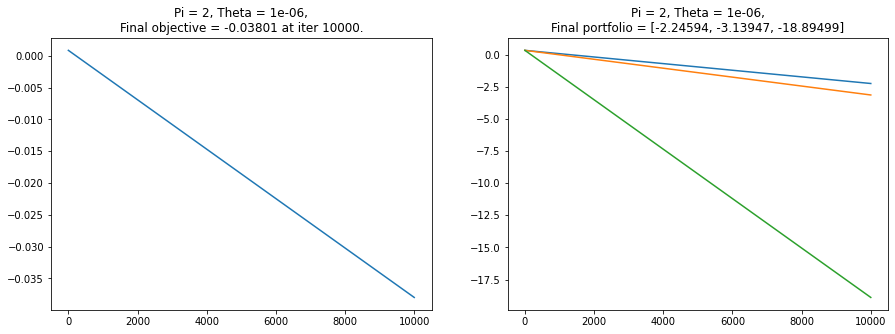

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize= (15, 5))

ax[0].plot(f_history[:it])
ax[1].plot(x_history[:it])

final_objective = round(f_history[it-1],5)
final_portfolio = [round(p,5) for p in x_history[it-1]]
print(f"Final objective = {final_objective}")
print(f"Final portfolio = {final_portfolio}")

ax[0].set_title(f"Pi = {pi}, Theta = {theta},\nFinal objective = {final_objective} at iter {it}.")
ax[1].set_title(f"Pi = {pi}, Theta = {theta},\nFinal portfolio = {final_portfolio}")

In [10]:
benchmark(ret_test, price_test, np.array(final_portfolio))

(array([[  -27046.89883785,  -243871.34690437, -1158017.42282831],
        [  -26895.04362994,  -243201.64791163, -1136140.28515199],
        [  -26850.93355679,  -242626.63838605, -1140302.27608595],
        [  -26886.13187745,  -245603.8219973 , -1136561.75633399],
        [  -26809.14337118,  -240675.65357884, -1142629.56026614],
        [  -26059.08885051,  -242385.58089548, -1138084.30827877],
        [  -24804.0146401 ,  -238337.70461134, -1174427.70866387],
        [  -25322.38045291,  -243165.05835314, -1238892.6822399 ],
        [  -24875.38753286,  -243802.37226114, -1185935.91538252],
        [  -24691.65464735,  -240192.80006074, -1172158.11393359],
        [  -24940.58044242,  -240787.70205906, -1130379.05690517]]),
 0.0036486460603612617)

In [11]:
# setup looping

result = []

thetas = [10**i for i in [-1, 1, 3, 5, 6]]
pis = [0.5, 2, 4, 6]
bts = [True, False]
moms = [True, False]
portfolio = np.array([1/3, 1/3, 1/3])

max_iter = 11000
m = len(portfolio)
ret = ret_train.values


loud = True

for theta in thetas:
    for pi in pis:
          for bt in bts:
                for mom in moms:
                    if loud:
                        print("*"*60)
                        print(f"RUNNING: theta={theta}, pi={pi}, bt={bt}, mom={mom}...")
                    
                    if bt:
                        step_epss = [1e-4]
                    else:
                        step_epss = [0.1, 0.01, 1]
                        step_epss
                    for step_eps in step_epss:
                        if loud:
                            print("\tstep_eps:", step_eps)
                        x_history = np.zeros((max_iter, m))
                        f_history = np.zeros(max_iter)
                        it, converged = run_grad_desc(
                            x = portfolio, 
                            ret = ret, 
                            pi = pi, theta = theta, x_history = x_history, f_history = f_history,
                            bt=bt, bt_a=0.5, bt_b=0.75, momentum=mom, mom_mu=0.8, 
                            max_iter = max_iter, step_eps=step_eps, 
                        )
                        # portfolio_history = np.hstack([x_history, (1 - x_history.sum(axis = 1)).reshape(-1, 1)])
                        final_objective = f_history[it-1]
                        final_portfolio = x_history[it-1]
                        result.append(
                            {
                                "theta": theta,
                                "pi": pi,
                                "backtrack": bt,
                                "momentum": mom,
                                "step_size/step_eps": step_eps,
                                "converged": converged,
                                "converged_iter": it,
                                "final_objective": final_objective,
                                "final_portfolio": final_portfolio
                            }
                        )
                        if loud:
                            print("*"*60)
                            print()


result_df = pd.DataFrame(result)



************************************************************
RUNNING: theta=0.1, pi=0.5, bt=True, mom=True...
	step_eps: 0.0001


<ipython-input-1-91121c86a48e>:34: RuntimeWarning: invalid value encountered in sqrt
  (deviation**pi).mean()


************************************************************

************************************************************
RUNNING: theta=0.1, pi=0.5, bt=True, mom=False...
	step_eps: 0.0001
************************************************************

************************************************************
RUNNING: theta=0.1, pi=0.5, bt=False, mom=True...
	step_eps: 0.1
************************************************************

	step_eps: 0.01
************************************************************

	step_eps: 1
************************************************************

************************************************************
RUNNING: theta=0.1, pi=0.5, bt=False, mom=False...
	step_eps: 0.1
************************************************************

	step_eps: 0.01
************************************************************

	step_eps: 1
************************************************************

************************************************************
RUN

In [13]:
def normalize_portfolio(x:np.ndarray):
    return x / x.sum()

result_df["portfolio_return"] = result_df.final_portfolio.apply(
    lambda x : benchmark(ret_test, price_test, normalize_portfolio(x))[1]
)

result_df

,theta,pi,backtrack,momentum,step_size/step_eps,converged,converged_iter,final_objective,final_portfolio,portfolio_return
0,0.1,0.5,True,True,0.0001,False,11000,NaN,"[0.3327716809381513, 0.3327738559519826, 0.330...",0.001018
1,0.1,0.5,True,False,0.0001,False,11000,NaN,"[0.33221491964763855, 0.33223566269703725, 0.3...",0.001022
2,0.1,0.5,False,True,0.1000,False,11000,NaN,"[0.24634529475193553, 0.008497897623813807, -0...",-0.003593
3,0.1,0.5,False,True,0.0100,False,11000,NaN,"[0.26939382631650466, 0.0073418851470248405, -...",-0.003659
4,0.1,0.5,False,True,1.0000,False,11000,NaN,"[2.020834056532895, 1.4663667182763473, -5.172...",-0.006236
...,...,...,...,...,...,...,...,...,...,...
155,1000000.0,6.0,False,True,0.0100,False,11000,7.433633e+06,"[42.4087782310219, 25.58993221933701, 157.9017...",0.000152
156,1000000.0,6.0,False,True,1.0000,False,11000,1.559104e+09,"[-8894.661989534865, -5367.14573208521, -33117...",0.000152
157,1000000.0,6.0,False,False,0.1000,False,11000,1.157289e+08,"[-660.2310757524147, -398.39157698306315, -245...",0.000152
158,1000000.0,6.0,False,False,0.0100,False,11000,1.485075e+07,"[-84.72323749030481, -51.1230285179939, -315.4...",0.000152
